<a href="https://colab.research.google.com/github/yongjulee0213/KLUE/blob/main/BaseLineCode_2023_01_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pwd

'/content'

In [2]:
#drive mount 해야 로컬에 있는 파일 가져올 수 있음
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Korean MRC Baseline

## Dependency
다음과 같은 라이브러리를 사용한다.
- [Konlpy](https://konlpy.org/ko/latest/index.html): 파이썬 한국어 NLP 처리기
- [Mecab-korean](https://bitbucket.org/eunjeon/mecab-ko-dic/src): 한국어 형태소 분석기 사용하여 tokenizing 진행


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 16.4 MB/s 
     |████████████████████████████████| 7.6 MB 48.8 MB/s 
     |████████████████████████████████| 182 kB 20.0 MB/s 


In [4]:
! apt-get install -y openjdk-8-jdk python3-dev
! pip install konlpy "tweepy<4.0.0"
! /bin/bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-dev is already the newest version (3.6.7-1~18.04).
python3-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jdk-headless openjdk-8-jre
  openjdk-8-jre-headless x11-utils
Suggested packages:
  gvfs openjdk-8-demo openjdk-8-source visualvm libnss-mdns
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0

## 데이터셋 구성
현재 JSON 데이터를 볼 수 있는 클래스를 하나 작성하자.

1 context 당 2 question이 있을 수도있음. 비정형데이터.
context와 question이 일대일 매핑이어야함.
question기준으로 indexing이 되어야함.
인덱스 저장방법 ; 0번째 question, 0번째 context, 0번째 paragraph =[0,0,0]
1번째 question, 0번째 context, 0번째 paragraph =[1,0,0]

Number of Samples: 12037
{\
**'guid'**: '798db07f0b9046759deed9d4a35ce31e', \
**'context'**: '올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도 늦은 이달 말께 장마가 시작될 전망이다.17일 기상청에 따르면 제주도 남쪽 먼바다에 있는 장마전선의 영향으로 이날 제주도 산간 및 내륙지역에 호우주의보가 내려지면서 곳곳에 100㎜에 육박하는 많은 비가 내렸다. 제주의 장마는 평년보다 2~3일, 지난해보다는 하루 일찍 시작됐다. 장마는 고온다습한 북태평양 기단과 한랭 습윤한 오호츠크해 기단이 만나 형성되는 장마전선에서 내리는 비를 뜻한다.장마전선은 18일 제주도 먼 남쪽 해상으로 내려갔다가 20일께 다시 북상해 전남 남해안까지 영향을 줄 것으로 보인다. 이에 따라 20-21일 남부지방에도 예년보다 사흘 정도 장마가 일찍 찾아올 전망이다. 그러나 장마전선을 밀어올리는 북태평양 고기압 세력이 약해 서울 등 중부지방은 평년보다 사나흘가량 늦은 이달 말부터 장마가 시작될 것이라는 게 기상청의 설명이다. 장마전선은 이후 한 달가량 한반도 중남부를 오르내리며 곳곳에 비를 뿌릴 전망이다. 최근 30년간 평균치에 따르면 중부지방의 장마 시작일은 6월24-25일이었으며 장마기간은 32일, 강수일수는 17.2일이었다.기상청은 올해 장마기간의 평균 강수량이 350-400㎜로 평년과 비슷하거나 적을 것으로 내다봤다. 브라질 월드컵 한국과 러시아의 경기가 열리는 18일 오전 서울은 대체로 구름이 많이 끼지만 비는 오지 않을 것으로 예상돼 거리 응원에는 지장이 없을 전망이다.',\
**'question'** : '북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?', \
 **'answers'**: \
 [{'text': '한 달가량', 'answer_start': 478},\
  {'text': '한 달', 'answer_start': 478}]}

In [5]:
from typing import List, Tuple, Dict, Any
import json
import random

class KoMRC:
    def __init__(self, data, indices: List[Tuple[int, int, int]]):
        self._data = data #원본 데이터
        self._indices = indices#question 단위의 인덱스

    # Json을 불러오는 메소드
    #한국어니까 utf-8 파일 경로를 받아 read모드로 json파일 가져오기
    @classmethod #factory 형태 - 재사용성
    def load(cls, file_path: str):
        with open(file_path, 'r', encoding='utf-8') as fd:
            data = json.load(fd)

        #인덱싱 만들기
        indices = []#인덱스 저장용
        for d_id, document in enumerate(data['data']):#data를 돌면서 "document"를 뽑아내고
            for p_id, paragraph in enumerate(document['paragraphs']):#'document' 돌면서 'paragraph'를 뽑고
                for q_id, _ in enumerate(paragraph['qas']):#'paragraph'안에서 'qas'를 뽑아냄.
                  #enumerate를 썼기에 index를 뽑아낼 수 있음.
                    indices.append((d_id, p_id, q_id))#[data번째, paragraph번째, qas번째]
        
        return cls(data, indices)#factory니까 cls만들어줘야함.

    # 데이터 셋을 잘라내는 메소드
    @classmethod
    def split(cls, dataset, eval_ratio: float=.1, seed=42):
      #cls에서 dataset을받아서, dataset(KOMRC)안에 indices를 구한다음,
      #랜덤으로 섞어서 train, dev로 분리
      #indieces를 앞에서부터 자르고, 뒤에서부터 잘라서 분리.
        indices = list(dataset._indices)
        random.seed(seed)
        random.shuffle(indices)
        train_indices = indices[int(len(indices) * eval_ratio):]
        eval_indices = indices[:int(len(indices) * eval_ratio)]

        #return시, dataset._data가 2번 들어가니 중복이 아닌가?
        #중복아님. 같은 객체를 가지고있는거라 원본데이터는 유일함.
        #데이터가 중복되지 않는다는 점에서 매우 효율적.
        return cls(dataset._data, train_indices), cls(dataset._data, eval_indices)

    def __getitem__(self, index: int) -> Dict[str, Any]:

      #index를 받아 qas에 맞는 _indices를 참조하여 인덱스 불러냄.
        d_id, p_id, q_id = self._indices[index]#
        paragraph = self._data['data'][d_id]['paragraphs'][p_id]

        context = paragraph['context']#context(지문)가져오기
        qa = paragraph['qas'][q_id]#qa(질문&정답)가져오기

        guid = qa['guid']#guid기준으로 테스트에서 출력할것이라 필요함.
        question = qa['question']#질문
        answers = qa['answers']#정답

        return {
            'guid': guid,
            'context': context,
            'question': question,
            'answers': answers
        }

    def __len__(self) -> int: 
        return len(self._indices)#인덱스 개수==데이터셋의 길이

`load` 메소드를 이용해서 Json 데이터를 불러올 수 있다.

In [6]:
dataset = KoMRC.load('/content/drive/MyDrive/6th-goorm-project-2-korean-mrc/train.json')#traindataset 가져오기
print("Number of Samples:", len(dataset))
print(dataset[0])#0번째 dataset 가져오기(question 기준, context가 중복될 수 있지, question은 중복 x)

Number of Samples: 12037
{'guid': '798db07f0b9046759deed9d4a35ce31e', 'context': '올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도 늦은 이달 말께 장마가 시작될 전망이다.17일 기상청에 따르면 제주도 남쪽 먼바다에 있는 장마전선의 영향으로 이날 제주도 산간 및 내륙지역에 호우주의보가 내려지면서 곳곳에 100㎜에 육박하는 많은 비가 내렸다. 제주의 장마는 평년보다 2~3일, 지난해보다는 하루 일찍 시작됐다. 장마는 고온다습한 북태평양 기단과 한랭 습윤한 오호츠크해 기단이 만나 형성되는 장마전선에서 내리는 비를 뜻한다.장마전선은 18일 제주도 먼 남쪽 해상으로 내려갔다가 20일께 다시 북상해 전남 남해안까지 영향을 줄 것으로 보인다. 이에 따라 20~21일 남부지방에도 예년보다 사흘 정도 장마가 일찍 찾아올 전망이다. 그러나 장마전선을 밀어올리는 북태평양 고기압 세력이 약해 서울 등 중부지방은 평년보다 사나흘가량 늦은 이달 말부터 장마가 시작될 것이라는 게 기상청의 설명이다. 장마전선은 이후 한 달가량 한반도 중남부를 오르내리며 곳곳에 비를 뿌릴 전망이다. 최근 30년간 평균치에 따르면 중부지방의 장마 시작일은 6월24~25일이었으며 장마기간은 32일, 강수일수는 17.2일이었다.기상청은 올해 장마기간의 평균 강수량이 350~400㎜로 평년과 비슷하거나 적을 것으로 내다봤다. 브라질 월드컵 한국과 러시아의 경기가 열리는 18일 오전 서울은 대체로 구름이 많이 끼지만 비는 오지 않을 것으로 예상돼 거리 응원에는 지장이 없을 전망이다.', 'question': '북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?', 'answers': [{'text': '한 달가량', 'answer_start': 478}, {'text': '한 달', 'answer_start': 478}]}


`split` 메소드를 이용하면 데이터 셋을 나눌 수 있다.

In [7]:
train_dataset, dev_dataset = KoMRC.split(dataset)#dataset=validation+train#seed를 변경하면 완전 다른 데이터셋이 나옴

print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))
print(dev_dataset[0])

Number of Train Samples: 10834
Number of Dev Samples: 1203
{'guid': '844e22ab28924c1697d5ac28801b34c1', 'context': '지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인으로 등장한 ‘2

단어 단위로 토큰화해서 정답 위치를 찾기 위하여 토큰화 및 위치 인덱싱을 하는 클래스를 상속을 통해 작성해 보자.

context, question tokenizing -> token을 숫자로 변환시켜서 모델에 넣어야함.



```
import konlpy
mecab=konlp.tag.Mecab() #형태소 분석기
mecab.morphs('한국어 테스트') #['한국어','테스트']
mecab.nouns(str)#명사만 들고옴.
mecab.pos#형태소단위 분석 + 형태소종류도 출력됨([('단어','형태소')]
```
- 조사, 명사가 잘 분리됨.
- morphs() ; 공백이 전부 사라지는 문제점.
> 단어 마지막에 숫자를 달아서 공백 표시

>> 문장 ; 지난해 주요 연극상을
morphs() ; 지난해,주요,연극,상,을

0 1 2 3 4 5 6 78 9 10\
지난해  주요  연극상을\
(0,2)  (4,5) (7,8) (9) (10)


In [8]:
from typing import Generator

import konlpy

class TokenizedKoMRC(KoMRC):#komrc 상속받아서 사용
    def __init__(self, data, indices: List[Tuple[int, int, int]]) -> None:
        super().__init__(data, indices)
        self._tagger = konlpy.tag.Mecab()#mecab 형태소 분석기

    #sentence를 받아서 tokenize하면서 시작부분과 종료 부분 인덱스를 찾을 수 있도록함.
    def _tokenize_with_position(self, sentence: str) -> List[Tuple[str, Tuple[int, int]]]:
        position = 0
        tokens = []
        for morph in self._tagger.morphs(sentence):#형태소 분리를하면서 
            position = sentence.find(morph, position)#string.find(찾을문자,어디서부터찾아?시작인덱스) ; 인덱스 반환
            tokens.append((morph, (position, position + len(morph))))#(분리한 형태소토큰,시작위치, 종료위치)
            position += len(morph)#다음 시작위치를 position으로 다시 정의
        return tokens
            
    def __getitem__(self, index: int) -> Dict[str, Any]:#tokenizing 진행
        sample = super().__getitem__(index)#komrc에 있는 __getitem__ 가져오기

        context, position = zip(*self._tokenize_with_position(sample['context']))
        context, position = list(context), list(position)
        question = self._tagger.morphs(sample['question'])
        
        #qas에서 answer분리하기
        '''
        지난해 [주요 연극상]을 나눠 가졌던
        정답 토큰 ; 주요 연극상
        start token ; 주요, end token- 연극상
        raw data에서는 [start token=주/478번째위치(character 단위)/답 ; 주요 연극상] 이라 주어짐.
        token기반으로 훈련할 것이기에, start token은 주요를 가르키고, end token은 상을 가르켜야함.
        ->token 단위와 character 단위가 맞지 않음. -> 맞춰주는 작업 필요. 478->78로 변환해야함.

        '''
        if sample['answers'] is not None:
            answers = []
            for answer in sample['answers']:
              #position을 돌면서, start/end위치 반환
                for start, (position_start, position_end) in enumerate(position):
                  #answer_start,position_start, position_end; character 기반
                    if position_start <= answer['answer_start'] < position_end:#character기반 token이 존재한다면
                        break
                else:#character기반 token이 없다면, 에러 발생
                    print(context, answer)
                    raise ValueError("No mathced start position")
                
                #character기반==token 기반 답이 같은지 확인
                #character 기반+공백제거?=token 기반과 단어가 같은가
                #주요 연극상->주요연극상 vs 주요연극상(token)
                target = ''.join(answer['text'].split(' '))#answer(답)을 공백기준으로 나눠서 합쳐줌. ∵ 모델에는 공백이 없는 텍스트가 들어가기에 맞춰주기 위함.
                source = ''
                for end, morph in enumerate(context[start:], start):#enumerate(,시작위치)
                    source += morph#공백없는 characterbased morph를 source에 저장
                    if target in source:
                        break
                else:
                    print(context, answer)
                    raise ValueError("No Matched end position")

                #token 기반 위치 저장
                answers.append({
                    'start': start,
                    'end': end
                })
        else:
            answers = None
        
        return {
            'guid': sample['guid'],
            'context_original': sample['context'],
            'context_position': position,
            'question_original': sample['question'],
            'context': context,
            'question': question,
            'answers': answers
        }
        

In [9]:
dataset = TokenizedKoMRC.load('/content/drive/MyDrive/6th-goorm-project-2-korean-mrc/train.json')

train_dataset, dev_dataset = TokenizedKoMRC.split(dataset)
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))
print(dev_dataset[0])

Number of Train Samples: 10834
Number of Dev Samples: 1203
{'guid': '844e22ab28924c1697d5ac28801b34c1', 'context_original': '지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인

Number of Train Samples: 10834\
Number of Dev Samples: 1203\
{'guid': '844e22ab28924c1697d5ac28801b34c1',\
'context_original': '지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인으로 등장한 ‘20세 고등학생’ 동교가 “이제부터 고시원 식구들에게 월세를 받지 않겠다”고 선언하면서 갑작스런 변화의 바람이 분다.날것 그대로의 직설 화법으로 풀어 놓는 풍성한 인생 이야기와 생동감 넘치는 극적 구조로 ‘집’의 본원적 의미와 삶에 대한 성찰의 기회를 제공한다는 평가를 받았다. 재연에서는 중견 배우 김세동이 장씨 역으로 출연해 박무영 김충근 한동규 류제승 김정민 등 초연 배우들과 호흡을 맞춘다.독일 극작가 롤란트 시멜페니히가 쓴 현대극 ‘황금용’은 독일 소도시에 있는 아시아계 간이식당을 배경으로 현대 물질사회와 세계화 속에 가려진 욕망과 폭력, 소외를 그린다. 치통을 앓지만 불법 체류자 신분으로 치과에 가지 못하는 한 젊은 중국인 요리사는 결국 비참한 최후를 맞는다.작품을 연출한 윤광진 용인대 교수는 “극의 배경은 유럽의 한 소도시이지만 서울이나 경기 안산의 어느 거리에서 일어나는 듯 우리에게 가깝게 다가오는 작품”이라며 “지하철에서 마주치는 외국인 근로자들, 그 옆에서 졸고 있는 우리의 이야기”라고 말했다. 이호성 남미정 이동근 한덕호 방현숙 등 초연 배우들이 다시 뭉친다.', \
'context_position': [(0, 3), (4, 6), (7, 9), (9, 10), (10, 11), (12, 14), (15, 17), (17, 18), (19, 20), (21, 22), (22, 23), (24, 26), (26, 27), (28, 29), (29, 30), (30, 31), (32, 35), (36, 39), (40, 42), (42, 43), (44, 45), (45, 47), (47, 48), (49, 53), (53, 55), (55, 57), (58, 60), (60, 61), (61, 63), (63, 65), (65, 66), (66, 67), (68, 70), (70, 72), (72, 73), (74, 76), (76, 77), (77, 79), (79, 80), (80, 82), (82, 83), (84, 85), (85, 86), (87, 89), (89, 90), (91, 92), (92, 96), (97, 100), (100, 102), (102, 104), (104, 105), (105, 107), (107, 108), (109, 111), (111, 112), (113, 116), (116, 118), (118, 120), (121, 124), (124, 125), (126, 128), (128, 129), (129, 130), (130, 131), (131, 132), (132, 134), (134, 135), (136, 139), (140, 144), (145, 148), (148, 151), (151, 153), (153, 154), (154, 155), (156, 158), (158, 160), (160, 162), (163, 165), (165, 166), (167, 168), (168, 170), (170, 171), (172, 173), (173, 174), (175, 176), (176, 178), (178, 179), (180, 181), (181, 182), (182, 183), (183, 185), (185, 187), (187, 188), (188, 189), (189, 190), (190, 191), (191, 193), (193, 194), (195, 197), (197, 198), (199, 201), (201, 204), (204, 205), (205, 206), (207, 209), (209, 211), (212, 214), (214, 215), (215, 217), (217, 218), (218, 219), (220, 223), (223, 225), (225, 226), (227, 229), (229, 231), (232, 233), (233, 236), (236, 238), (238, 239), (239, 240), (240, 241), (241, 242), (242, 244), (244, 245), (246, 249), (250, 252), (252, 253), (254, 257), (257, 258), (258, 259), (259, 260), (260, 261), (262, 264), (265, 267), (268, 269), (269, 270), (271, 273), (274, 276), (276, 277), (278, 279), (279, 280), (281, 284), (285, 286), (286, 288), (289, 291), (291, 292), (293, 295), (296, 298), (298, 299), (299, 301), (302, 304), (304, 308), (309, 311), (311, 312), (312, 313), (314, 317), (317, 318), (319, 321), (321, 322), (323, 325), (325, 326), (327, 328), (329, 330), (330, 331), (332, 334), (334, 335), (335, 336), (337, 338), (338, 342), (343, 346), (346, 347), (347, 348), (349, 351), (351, 352), (353, 354), (354, 355), (356, 358), (358, 359), (360, 363), (363, 364), (365, 368), (368, 369), (370, 372), (372, 373), (374, 379), (380, 383), (383, 384), (384, 385), (386, 390), (390, 391), (391, 392), (393, 396), (397, 398), (399, 401), (401, 402), (403, 404), (404, 405), (405, 406), (407, 410), (410, 411), (412, 414), (414, 416), (417, 418), (419, 421), (421, 422), (423, 426), (426, 427), (428, 430), (430, 431), (432, 434), (434, 435), (435, 436), (437, 439), (439, 440), (440, 441), (442, 444), (444, 446), (446, 447), (448, 451), (451, 452), (453, 454), (454, 455), (455, 456), (456, 457), (458, 460), (460, 461), (462, 463), (463, 464), (464, 465), (466, 468), (468, 469), (470, 472), (472, 473), (473, 474), (474, 476), (477, 479), (479, 480), (480, 481), (482, 484), (484, 485), (485, 486), (487, 489), (490, 493), (494, 495), (495, 497), (498, 500), (500, 501), (502, 505), (506, 508), (508, 509), (510, 512), (512, 513), (513, 514), (515, 519), (520, 522), (522, 523), (524, 526), (526, 527), (527, 528), (529, 530), (530, 531), (532, 533), (533, 537), (537, 538), (539, 542), (542, 543), (544, 545), (545, 547), (548, 551), (551, 552), (552, 553), (553, 554), (555, 556), (556, 558), (558, 559), (559, 561), (561, 563), (563, 566), (566, 568), (568, 569), (570, 571), (572, 574), (574, 575), (576, 577), (577, 581), (581, 582), (583, 585), (585, 586), (587, 589), (590, 593), (593, 594), (594, 595), (595, 596), (597, 599), (599, 600), (600, 601), (602, 603), (603, 605), (605, 606), (606, 607), (608, 610), (610, 611), (611, 612), (613, 614), (614, 615), (616, 618), (618, 619), (620, 622), (622, 623), (624, 626), (626, 627), (628, 630), (631, 634), (634, 635), (636, 638), (638, 639), (640, 642), (642, 644), (644, 645), (646, 648), (648, 649), (649, 650), (651, 653), (654, 657), (658, 660), (660, 661), (661, 662), (663, 665), (665, 666), (666, 667), (667, 668), (668, 669), (670, 672), (672, 673), (673, 674), (675, 676), (677, 679), (679, 681), (682, 684), (684, 685), (685, 686), (687, 689), (690, 693), (693, 694), (695, 697), (697, 698), (699, 702), (703, 706), (707, 708), (709, 711), (712, 714), (714, 715), (715, 716), (717, 720), (721, 723), (723, 725), (725, 726), (726, 727), (727, 729), (729, 730), (731, 732), (732, 733), (733, 734), (734, 735), (735, 736), (737, 739), (739, 740), (740, 741), (742, 744), (745, 746), (746, 747), (748, 749), (749, 751), (751, 752), (753, 755), (755, 756), (756, 757), (758, 761), (761, 762), (763, 765), (766, 767), (767, 768), (769, 771), (771, 772), (772, 773), (774, 776), (776, 777), (778, 780), (780, 781), (782, 784), (785, 787), (787, 788), (789, 790), (790, 791), (791, 793), (793, 794), (795, 799), (799, 800), (801, 802), (802, 804), (805, 806), (806, 808), (808, 809), (809, 810), (811, 813), (814, 816), (817, 818), (818, 819), (819, 820), (820, 821), (822, 825), (826, 828), (828, 829), (830, 832), (833, 835), (835, 836), (837, 838), (838, 839), (840, 842), (842, 843), (843, 844), (844, 845), (846, 848), (848, 849), (850, 852), (852, 853), (854, 856), (856, 857), (858, 860), (860, 862), (862, 863), (864, 867), (867, 868), (869, 872), (873, 875), (875, 877), (878, 880), (880, 881), (882, 883), (883, 885), (885, 886), (887, 891), (891, 892), (893, 895), (895, 896), (897, 898), (898, 900), (900, 902), (903, 906), (907, 909), (909, 910), (910, 912), (913, 915), (915, 916), (917, 918), (918, 919), (920, 921), (921, 922), (922, 923), (923, 924), (924, 925), (926, 928), (928, 929), (929, 931), (932, 936), (937, 939), (939, 940), (941, 943), (943, 944), (945, 947), (947, 948), (948, 949), (949, 950), (951, 954), (954, 955), (956, 958), (959, 961), (961, 963), (964, 965), (965, 966), (967, 968), (968, 969), (970, 972), (972, 973), (974, 976), (977, 980), (980, 981), (982, 985), (986, 988), (988, 989), (990, 991), (991, 992), (993, 995), (995, 996), (997, 998), (998, 999), (999, 1000), (1000, 1001), (1002, 1004), (1004, 1005), (1006, 1008), (1008, 1009), (1010, 1011), (1011, 1012), (1013, 1015), (1016, 1018), (1018, 1019), (1020, 1022), (1022, 1023), (1024, 1026), (1026, 1029), (1030, 1032), (1032, 1033), (1034, 1035), (1035, 1036), (1036, 1037), (1037, 1038), (1039, 1041), (1041, 1043), (1043, 1044), (1045, 1047), (1048, 1050), (1051, 1054), (1054, 1055), (1056, 1057), (1057, 1058), (1059, 1060), (1060, 1062), (1063, 1065), (1065, 1066), (1067, 1070), (1071, 1074), (1075, 1078), (1079, 1082), (1083, 1086), (1087, 1088), (1089, 1091), (1092, 1094), (1094, 1095), (1095, 1096), (1097, 1099), (1099, 1100), (1101, 1104), (1104, 1105), (1105, 1107), (1108, 1111), (1112, 1115), (1116, 1118), (1118, 1121), (1121, 1122), (1123, 1124), (1125, 1128), (1129, 1130), (1130, 1133), (1133, 1134), (1134, 1135), (1136, 1138), (1139, 1140), (1140, 1142), (1142, 1143), (1144, 1145), (1145, 1146), (1147, 1150), (1150, 1151), (1152, 1156), (1156, 1157), (1158, 1160), (1160, 1162), (1163, 1165), (1166, 1168), (1168, 1170), (1170, 1171), (1172, 1174), (1174, 1175), (1176, 1177), (1177, 1178), (1179, 1182), (1183, 1185), (1185, 1186), (1187, 1189), (1189, 1190), (1191, 1193), (1193, 1194), (1195, 1198), (1198, 1199), (1200, 1202), (1202, 1203), (1204, 1205), (1205, 1207), (1208, 1210), (1211, 1213), (1213, 1214), (1215, 1217), (1217, 1219), (1220, 1222), (1222, 1223), (1224, 1225), (1225, 1226), (1227, 1229), (1229, 1230), (1231, 1232), (1233, 1234), (1234, 1235), (1236, 1239), (1240, 1243), (1243, 1244), (1245, 1247), (1248, 1250), (1250, 1251), (1252, 1254), (1254, 1255), (1256, 1257), (1257, 1259), (1259, 1260), (1260, 1262), (1262, 1263), (1264, 1266), (1266, 1267), (1268, 1271), (1272, 1274), (1274, 1275), (1276, 1278), (1278, 1279), (1280, 1281), (1281, 1282), (1282, 1283), (1284, 1286), (1286, 1287), (1288, 1290), (1290, 1291), (1292, 1293), (1294, 1297), (1297, 1298), (1298, 1300), (1301, 1303), (1303, 1305), (1306, 1308), (1309, 1311), (1311, 1312), (1313, 1315), (1316, 1318), (1318, 1320), (1321, 1324), (1324, 1325), (1326, 1327), (1328, 1330), (1330, 1332), (1333, 1335), (1335, 1336), (1337, 1340), (1340, 1341), (1342, 1344), (1344, 1345), (1345, 1346), (1346, 1348), (1349, 1350), (1350, 1353), (1353, 1355), (1356, 1359), (1359, 1360), (1361, 1364), (1365, 1368), (1368, 1369), (1369, 1370), (1371, 1372), (1373, 1374), (1374, 1376), (1377, 1378), (1378, 1379), (1380, 1381), (1381, 1382), (1383, 1385), (1385, 1386), (1387, 1390), (1390, 1391), (1391, 1393), (1394, 1395), (1395, 1396), (1396, 1397), (1397, 1398), (1399, 1402), (1403, 1406), (1407, 1410), (1411, 1414), (1415, 1416), (1416, 1418), (1419, 1420), (1421, 1423), (1424, 1426), (1426, 1427), (1427, 1428), (1429, 1431), (1432, 1435), (1435, 1436)], \
'question_original': '윤광진 교수가 연출한 연극이 앙코르 공연을 하는 장소는 어디인가?', 'context': ['지난해', '주요', '연극', '상', '을', '나눠', '가졌', '던', '세', '편', '의', '작품', '이', '올', '봄', '에', '나란히', '앙코르', '무대', '를', '갖', '는다', '.', '대한민국', '연극', '대상', '연기', '·', '무대', '예술', '상', ',', '동아', '연극', '상', '작품', '·', '희곡', '·', '연기', '상', '등', '을', '수상', '한', '‘', '알리바이', '연대기', '’(', '17', '~', '20', '일', '대학', '로', '아르코', '예술', '극장', '대극장', ',', '25', '일', '~', '5', '월', '11', '일', '서계동', '국립극단', '백성희', '장민호', '극장', ')', ',', '연극', '대상', '에서', '대상', '과', '희', '곡상', '을', '받', '은', '‘', '여기', '가', '집', '이', '다', '’(', '18', '일', '~', '5', '월', '22', '일', '대학', '로', '연우', '소극장', ')', ',', '연극', '대상', '작품', '·', '연출', '상', '과', '김상열', '연극', '상', '수상', '작인', '‘', '황금용', '’(', '5', '월', '9', '~', '18', '일', '서강대', '메리', '홀', '대극장', ')', '이', '다', '.', '초연', '당시', '짧', '은', '상연', '기간', '과', '낮', '은', '인지도', '등', '으로', '공연', '을', '놓친', '연극', '팬', '에겐', '평단', '으로부터', '작품', '성', '을', '인정받', '은', '수작', '을', '관람', '할', '수', '있', '는', '기회', '다', '.', '‘', '알리바이', '연대기', '’', '는', '희곡', '을', '쓰', '고', '연출', '한', '김재엽', '의', '가족사', '에', '근거', '한', '다큐멘터리', '드라마', '다', '.', '1930', '년', '에', '태어난', '한', '개인', '의', '사', '적', '인', '연대기', '를', '바탕', '으로', '그', '사이', '를', '파고드', '는', '역사', '적', '순간', '들', '을', '정밀', '하', '게', '조명', '한다', '.', '연출가', '는', '“', '공', '적', '인', '권력', '이', '사', '적', '인', '권리', '를', '지켜', '주', '기', '보다', '억압', '하', '기', '일쑤', '였', '던', '한국', '현대사', '속', '에서', '개인', '은', '언제나', '무죄', '를', '입증', '하', '며', '하루하루', '자신', '을', '지켜', '내', '야', '하', '는', '‘', '알리바이', '의', '연대기', '’', '속', '에서', '살아왔', '다', '”', '고', '말', '한다', '.', '한국', '연극', '평론가', '협회', '는', '이', '작품', '을', '‘', '2013', '년', '올해', '의', '연극', '베스트', '3', '’', '로', '선정', '하', '며', '“', '촘촘', '하', '고', '세세', '하', '게', '삶', '에', '천착', '해', '개인', '과', '역사', '에', '대한', '이분법', '적', '관점', '을', '극복', '한다', '.', '정치', '극', '에', '대한', '새로운', '가능', '성', '을', '보여', '줬', '다', '”', '고', '평했', '다', '.', '이', '작품', '으로', '연기', '상', '을', '휩쓴', '남명렬', '을', '비롯', '해', '지춘성', '정원조', '등', '초연', '배우', '들', '이', '그대로', '출연', '한다', '.', '‘', '여기', '가', '집', '이', '다', '’', '는', '허름', '하', '고', '볼품', '없', '는', '‘', '20', '년', '전통', '’', '의', '고시원', '에', '모여', '사', '는', '사람', '들', '의', '절망', '과', '희망', '을', '그린', '작품', '.', '‘', '차', '력사', '와', '아코디언', '’', '‘', '택배', '왔', '어요', '’', '를', '만든', '극단', '이', '와', '삼', '의', '장우재', '대표', '가', '직접', '대본', '을', '쓰', '고', '연출', '했', '다', '.', '나름', '의', '규칙', '을', '가지', '고', '평화', '로웠', '던', '고시원', '에', '새로운', '주인', '으로', '등장', '한', '‘', '20', '세', '고등학생', '’', '동교', '가', '“', '이제', '부터', '고시원', '식구', '들', '에게', '월세', '를', '받', '지', '않', '겠', '다', '”', '고', '선언', '하', '면서', '갑작스런', '변화', '의', '바람', '이', '분다', '.', '날', '것', '그대로', '의', '직설', '화법', '으로', '풀', '어', '놓', '는', '풍성', '한', '인생', '이야기', '와', '생동감', '넘치', '는', '극', '적', '구조', '로', '‘', '집', '’', '의', '본원', '적', '의미', '와', '삶', '에', '대한', '성찰', '의', '기회', '를', '제공', '한다는', '평가', '를', '받', '았', '다', '.', '재연', '에서', '는', '중견', '배우', '김세동', '이', '장', '씨', '역', '으로', '출연', '해', '박무영', '김충근', '한동규', '류제승', '김정민', '등', '초연', '배우', '들', '과', '호흡', '을', '맞춘다', '.', '독일', '극작가', '롤란트', '시멜', '페니히', '가', '쓴', '현대극', '‘', '황금용', '’', '은', '독일', '소', '도시', '에', '있', '는', '아시아', '계', '간이식당', '을', '배경', '으로', '현대', '물질', '사회', '와', '세계', '화', '속', '에', '가려진', '욕망', '과', '폭력', ',', '소외', '를', '그린다', '.', '치통', '을', '앓', '지만', '불법', '체류', '자', '신분', '으로', '치과', '에', '가', '지', '못하', '는', '한', '젊', '은', '중국인', '요리사', '는', '결국', '비참', '한', '최후', '를', '맞', '는다', '.', '작품', '을', '연출', '한', '윤광진', '용인', '대', '교수', '는', '“', '극', '의', '배경', '은', '유럽', '의', '한', '소도시', '이', '지만', '서울', '이나', '경기', '안산', '의', '어느', '거리', '에서', '일어나', '는', '듯', '우리', '에게', '가깝', '게', '다가오', '는', '작품', '”', '이', '라며', '“', '지하철', '에서', '마주치', '는', '외국인', '근로자', '들', ',', '그', '옆', '에서', '졸', '고', '있', '는', '우리', '의', '이야기', '”', '라고', '말', '했', '다', '.', '이호성', '남미정', '이동근', '한덕호', '방', '현숙', '등', '초연', '배우', '들', '이', '다시', '뭉친다', '.'],\
 'question': ['윤광진', '교수', '가', '연출', '한', '연극', '이', '앙코르', '공연', '을', '하', '는', '장소', '는', '어디', '인가', '?'], \
 'answers': [{'start': 125, 'end': 128}]}
 token based index로 변환됨.

In [10]:
sample = dev_dataset[0]
#답 출력
#0번째qas에서 start의 위치부터 end의 위치 출력
print(sample['context'][sample['answers'][0]['start']:sample['answers'][0]['end']+1])
#dev_dataset[0][sample['context'][sample['answers'][0]['start']:sample['answers'][0]['end']+1]

['서강대', '메리', '홀', '대극장']


## Vocab 생성 및 Indexing
토큰화된 데이터 셋을 기준으로 Vocab을 만들고 인덱싱을 하는 `Indexer`를 만들자.
vocabulary 만들기

In [11]:
from typing import Sequence
from collections import Counter
from itertools import chain

from tqdm.notebook import tqdm

class Indexer:
    def __init__(self,
        id2token: List[str], 
        max_length: int=1024,
        pad: str='<pad>', unk: str='<unk>', cls: str='<cls>', sep: str='<sep>'
    ):
        self.pad = pad
        self.unk = unk #mecab기반으로 했기에 unknown token이 무조건 발생.
        self.cls = cls 
        self.sep = sep
        self.special_tokens = [pad, unk, cls, sep]

        self.max_length = max_length

        self.id2token = self.special_tokens + id2token#speical token과 id2token을 붙여서 만들어줌.
        self.token2id = {token: token_id for token_id, token in enumerate(self.id2token)}#token에서 id로 변환하는 것도 만들어줌.

    #property를 통해 접근이 쉽도록함.
    @property
    def vocab_size(self):
        return len(self.id2token)#id에서 token이 된 것의 길이
    
    @property
    def pad_id(self):
        return self.token2id[self.pad]
    @property
    def unk_id(self):
        return self.token2id[self.unk]
    @property
    def cls_id(self):
        return self.token2id[self.cls]
    @property
    def sep_id(self):
        return self.token2id[self.sep]

    @classmethod
    #vocab쌓기 ; dataset을 받아서 frequency하여 5개 미만으로 나오는것을 잘라버리기.
    def build_vocab(cls, dataset: TokenizedKoMRC, min_freq: int=5):
        counter = Counter(chain.from_iterable(
            sample['context'] + sample['question']
            for sample in tqdm(dataset, desc="Counting Vocab")
        ))#전체(지문,질문) 단어 개수들 세기
        #단어가 5번 이상 나오면 살리고, 아니면 죽여
        return cls([word for word, count in counter.items() if count >= min_freq])
    
    def decode(self,
        token_ids: Sequence[int]
    ):
        return [self.id2token[token_id] for token_id in token_ids]
    
    #encode ; token based index dictionary를 받아서 tokenizing
    def sample2ids(self,sample: Dict[str, Any],) -> Dict[str, Any]:

        #token2id ; 숫자로 변환, 없는 것은 unk_id로 치환
        #dict.get(key,default=None)
        context = [self.token2id.get(token, self.unk_id) for token in sample['context']]
        question = [self.token2id.get(token, self.unk_id) for token in sample['question']]

        '''
        input format ; [cls] question_tokens [sep] context_tokens [sep]
        ∴ [cls],[sep]*2이 항상 들어가게끔 만들어줘야함.
        ∴ token 3개가 들어가므로 전체길이(question+context)에서 3을 빼줌.
        전체 길이가 max_length를 넘으면 context를 자름.(question을 자르면 안됨)
        '''
        context = context[:self.max_length-len(question)-3] # context길이=전체-question길이-speical token개수
        
        input_ids = [self.cls_id] + question + [self.sep_id] + context + [self.sep_id]#input format

        #위치정보 ; sentence A,B 구분자 인위로 넣어줌
        #[cls] question_tokens [sep] context_tokens [sep]
        #0     000000000000000    1  11111111111111   1
        #[cls] 1개이므로 +1 / [sep] 2개 이므로 +2
        token_type_ids = [0] * (len(question) + 1) + [1] * (len(context) + 2)

        '''
        answer의 start_index, end_index가 context에서의 번째이기에,
        input_ids에서의 번째로 변경해줘야한다.
        ->input_ids에서의 인덱스=기존 context에서의 index+question 길이+special token(cls, sep)의 길이(2)
        '''
        if sample['answers'] is not None:
            answer = sample['answers'][0]
            #-1을 하여 max_length를 넘지 않게끔 만들어줌.
            #1 question 당 2 answers 존재함.
            #여러개의 정답이 존재하는 경우, 첫번째 정답만을 사용
            start = min(answer['start'] + len(question) + 2, self.max_length - 1)
            end = min(answer['end'] + len(question) + 2, self.max_length - 1)
        else:#정답이 아예 없을 경우
            start = None
            end = None

        
        return {
            'guid': sample['guid'],
            'context': sample['context_original'],
            'question': sample['question_original'],
            'position': sample['context_position'],
            'input_ids': input_ids,
            'token_type_ids': token_type_ids,
            'start': start,
            'end': end
        }

In [12]:
indexer = Indexer.build_vocab(dataset)#tqdm이 있어서 바가 나타남
print(indexer.sample2ids(dev_dataset[0]))

Counting Vocab:   0%|          | 0/12037 [00:00<?, ?it/s]

{'guid': '844e22ab28924c1697d5ac28801b34c1', 'context': '지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인으로 등장한 ‘20세 고등학생’ 동교가 “이제부터 고시원 식구들에게 월세를 받지 않겠다”고 선언하면서 갑작스런 변화의 바람

쉽게 Indexer를 활용하기 위해 Indexer가 포함된 데이터 셋을 만들자.\
샘플마다 각각 숫자로 만들기는 불편함.

In [13]:
class IndexerWrappedDataset:
    def __init__(self, dataset: TokenizedKoMRC, indexer: Indexer) -> None:
        self._dataset = dataset
        self._indexer = indexer

    def __len__(self) -> int:
        return len(self._dataset)
    
    def __getitem__(self, index: int) -> Dict[str, Any]:
      #indexer해서 받아옴
        sample = self._indexer.sample2ids(self._dataset[index])
        #transformer쓸거면,attention_mask에 대한 정보가 필요함. 아직 패딩안해서 전부 볼꺼니까 전부 1로 설정
        sample['attention_mask'] = [1] * len(sample['input_ids'])

        return sample


In [14]:
indexed_train_dataset = IndexerWrappedDataset(train_dataset, indexer)
indexed_dev_dataset = IndexerWrappedDataset(dev_dataset, indexer)

sample = indexed_dev_dataset[0]
print(sample['input_ids'], sample['attention_mask'], sample['token_type_ids'], sample['start'], sample['end'])

[2, 1, 1100, 7, 2226, 71, 4336, 30, 25656, 1139, 97, 57, 39, 2874, 39, 2684, 974, 170, 3, 67, 2912, 4336, 830, 97, 1250, 1278, 553, 1607, 2344, 41, 2239, 30, 4, 3276, 32, 6946, 25656, 4344, 82, 2339, 1386, 15, 1016, 4336, 257, 4355, 695, 4344, 4335, 830, 66, 2412, 4336, 830, 2239, 695, 2386, 695, 4355, 830, 17, 97, 834, 71, 183, 36128, 12542, 588, 8, 64, 90, 9, 276, 142, 1, 4335, 4333, 29910, 66, 132, 9, 64, 246, 130, 530, 9, 24315, 19208, 1, 29106, 4333, 175, 66, 4336, 257, 11, 257, 74, 6503, 1, 97, 649, 20, 183, 2830, 7, 635, 30, 14, 588, 85, 9, 64, 246, 130, 1375, 9, 276, 142, 1, 19205, 175, 66, 4336, 257, 2239, 695, 2226, 830, 74, 33837, 4336, 830, 834, 28079, 183, 1, 588, 246, 130, 1513, 64, 85, 9, 6741, 1807, 1011, 29910, 175, 30, 14, 15, 9493, 1293, 2500, 20, 5450, 135, 74, 981, 20, 2426, 17, 43, 1139, 97, 11653, 4336, 2839, 7081, 9478, 2462, 2239, 332, 97, 4133, 20, 17011, 97, 12211, 407, 402, 38, 39, 950, 14, 15, 183, 36128, 12542, 191, 39, 2386, 97, 2286, 243, 2226, 71, 1, 41

**input_ids**[2, 1, 1100, 7, 2226, 71, 4336, 30, 25656, 1139, 97, 57, 39, 2874, 39, 2684, 974, 170, 3, 67, 2912, 4336, 830, 97, 1250, 1278, 553, 1607, 2344, 41, 2239, 30, 4, 3276, 32, 6946, 25656, 4344, 82, 2339, 1386, 15, 1016, 4336, 257, 4355, 695, 4344, 4335, 830, 66, 2412, 4336, 830, 2239, 695, 2386, 695, 4355, 830, 17, 97, 834, 71, 183, 36128, 12542, 588, 8, 64, 90, 9, 276, 142, 1, 4335, 4333, 29910, 66, 132, 9, 64, 246, 130, 530, 9, 24315, 19208, 1, 29106, 4333, 175, 66, 4336, 257, 11, 257, 74, 6503, 1, 97, 649, 20, 183, 2830, 7, 635, 30, 14, 588, 85, 9, 64, 246, 130, 1375, 9, 276, 142, 1, 19205, 175, 66, 4336, 257, 2239, 695, 2226, 830, 74, 33837, 4336, 830, 834, 28079, 183, 1, 588, 246, 130, 1513, 64, 85, 9, 6741, 1807, 1011, 29910, 175, 30, 14, 15, 9493, 1293, 2500, 20, 5450, 135, 74, 981, 20, 2426, 17, 43, 1139, 97, 11653, 4336, 2839, 7081, 9478, 2462, 2239, 332, 97, 4133, 20, 17011, 97, 12211, 407, 402, 38, 39, 950, 14, 15, 183, 36128, 12542, 191, 39, 2386, 97, 2286, 243, 2226, 71, 1, 41, 1, 32, 6784, 71, 13208, 5910, 14, 15, 8803, 126, 32, 1747, 71, 878, 41, 802, 145, 198, 12542, 82, 1802, 43, 248, 476, 82, 16534, 39, 1950, 145, 4419, 264, 97, 8526, 57, 116, 2801, 84, 15, 4373, 39, 425, 3184, 145, 198, 5937, 30, 802, 145, 198, 2172, 82, 11548, 293, 475, 22, 6693, 57, 475, 7874, 482, 553, 149, 6736, 1179, 11, 878, 20, 9520, 11562, 82, 4794, 57, 123, 28915, 554, 97, 11548, 302, 1310, 57, 39, 183, 36128, 41, 12542, 191, 1179, 11, 19596, 14, 443, 243, 26, 84, 15, 149, 4336, 4467, 4684, 39, 30, 2239, 97, 183, 682, 126, 137, 41, 4336, 5487, 65, 191, 142, 196, 57, 123, 425, 19156, 57, 243, 6540, 57, 116, 938, 32, 21429, 93, 878, 74, 1950, 32, 400, 10340, 145, 4724, 97, 10159, 84, 15, 3718, 5739, 32, 400, 1833, 330, 332, 97, 2992, 4367, 14, 443, 243, 9937, 14, 15, 30, 2239, 43, 4355, 830, 97, 9514, 35455, 97, 866, 93, 1, 1, 17, 9493, 4349, 264, 30, 1264, 2238, 84, 15, 183, 2830, 7, 635, 30, 14, 191, 39, 8555, 57, 243, 1, 167, 39, 183, 90, 126, 2884, 191, 41, 28120, 32, 6630, 802, 39, 940, 264, 41, 9099, 74, 2714, 97, 4215, 2239, 15, 183, 423, 8600, 172, 1, 191, 183, 20588, 876, 4369, 191, 82, 1992, 4332, 30, 172, 2390, 41, 1, 1022, 7, 2096, 5951, 97, 2286, 243, 2226, 242, 14, 15, 2349, 41, 4768, 97, 2088, 243, 899, 13201, 553, 28120, 32, 1833, 10353, 43, 1321, 71, 183, 90, 1607, 6412, 191, 1, 7, 425, 1947, 114, 28120, 2892, 264, 806, 3055, 82, 649, 160, 161, 442, 14, 443, 243, 1198, 57, 52, 1743, 345, 41, 4158, 30, 31083, 15, 1706, 99, 1264, 41, 29093, 14646, 43, 1396, 108, 3185, 39, 645, 71, 2291, 2251, 172, 4924, 4943, 39, 5739, 145, 1860, 142, 183, 635, 191, 41, 14031, 145, 1234, 172, 938, 32, 400, 10523, 41, 950, 82, 874, 1327, 244, 82, 649, 464, 14, 15, 25872, 11, 39, 1843, 4349, 1, 30, 1086, 1912, 3113, 43, 2238, 93, 1, 1, 1, 1, 1, 17, 9493, 4349, 264, 74, 16010, 97, 28293, 15, 5172, 9487, 1, 1, 1, 7, 1934, 19200, 183, 1, 191, 20, 5172, 5589, 716, 32, 38, 39, 693, 1038, 1, 97, 5752, 43, 1077, 3418, 325, 172, 712, 189, 1179, 32, 6482, 15736, 74, 3698, 66, 9686, 82, 6957, 15, 1, 97, 10405, 158, 3696, 10469, 1146, 5344, 43, 10702, 32, 7, 160, 4620, 39, 71, 5787, 20, 6679, 8398, 39, 1279, 9568, 71, 14870, 82, 881, 1386, 15, 2239, 97, 2226, 71, 1, 1223, 634, 1100, 39, 425, 5739, 41, 5752, 20, 768, 41, 71, 12050, 30, 158, 16, 794, 151, 6008, 41, 1705, 164, 11, 5575, 39, 2327, 1092, 806, 3114, 116, 5169, 39, 2239, 443, 30, 724, 425, 3126, 11, 21870, 39, 5505, 413, 264, 66, 248, 867, 11, 12581, 243, 38, 39, 1092, 41, 2251, 443, 735, 26, 242, 14, 15, 1, 1, 34839, 1, 2476, 1, 17, 9493, 4349, 264, 30, 91, 25334, 15, 3]\
**attention_mask** [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] \
**token_type_ids**[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] \
**start_token** 144 
**end_token** 147

여기까지가 전처리과정

## Transformer Encoder를 활용한 MRC 모델
![Bert for MRC](https://miro.medium.com/max/340/1*cXDOP0gsE7Zp8-sgZqYfTA.png)

Transformer 인코더 마지막에 Linear Layer를 붙여 정답의 시작과 끝을 맞추는 간단한 모델을 생성보자.

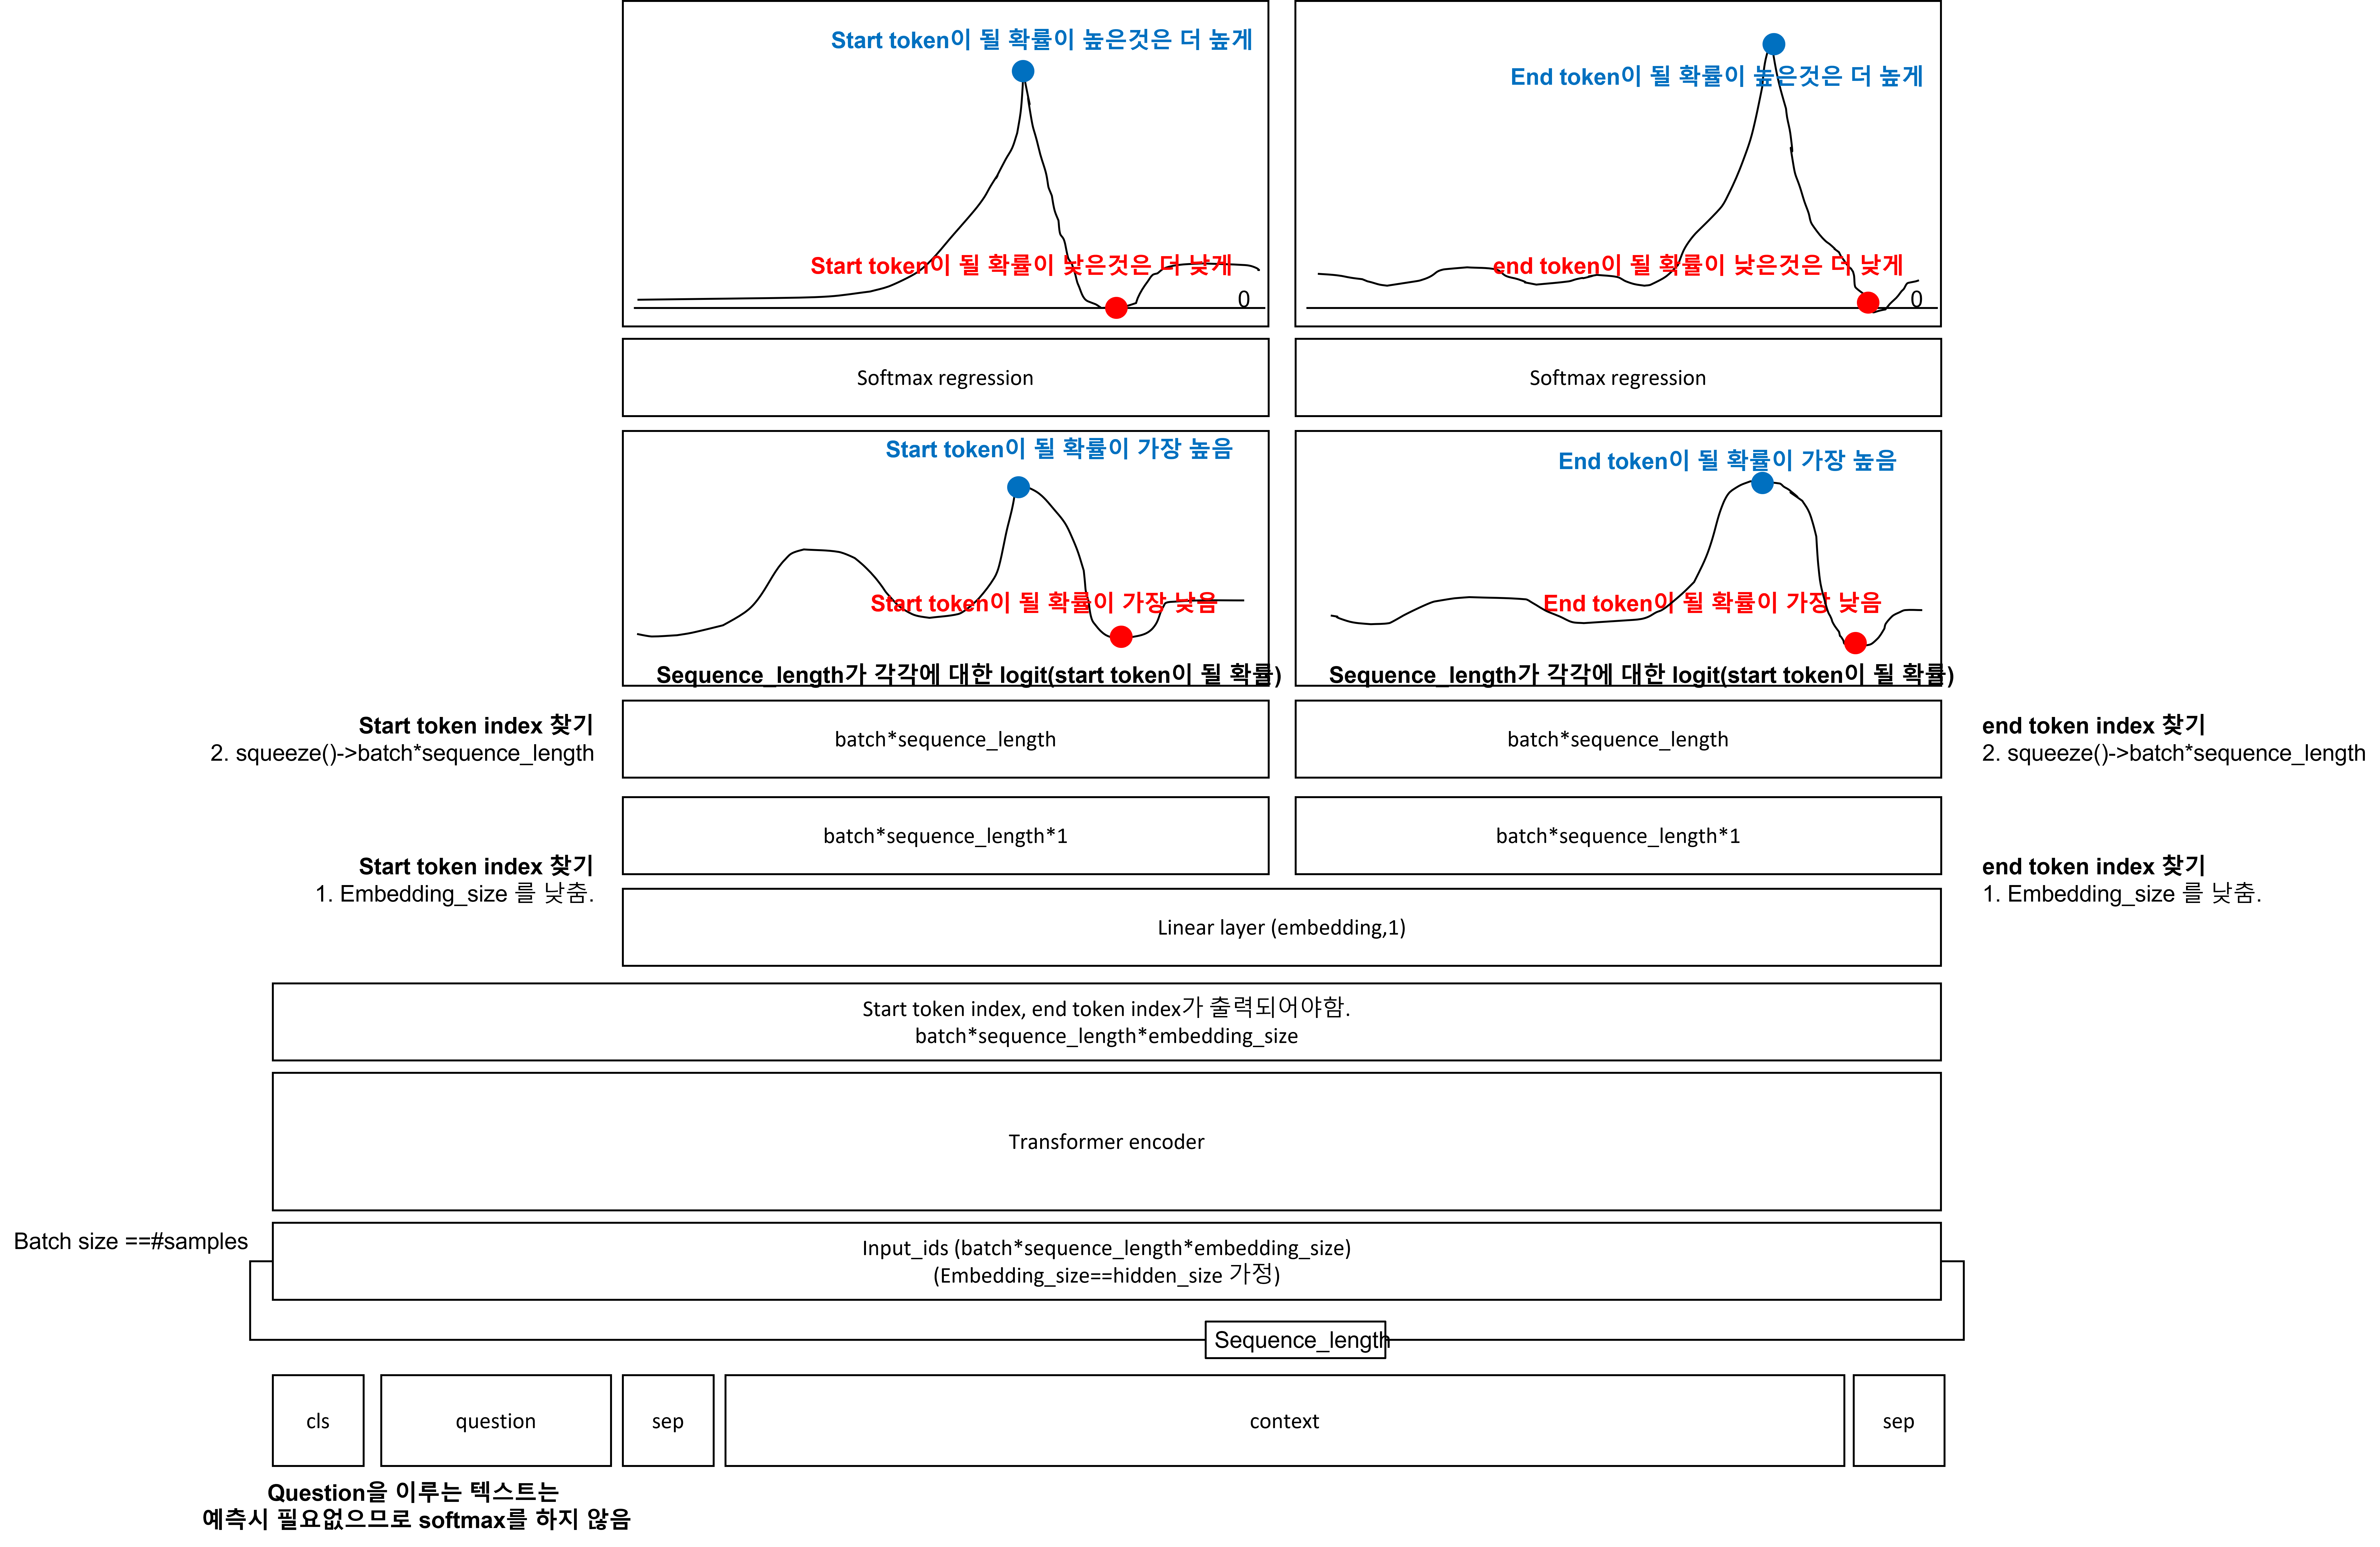

question ; 정답은?\
context ; 지난해 주요 연극상을 나눠가졌다.\
정답 ; 주요 연극상\
input_ids ; [cls] 정답 은 [sep] 지난해 **주요 연극 상** 은 나눠 가지 었 다 [sep]\
answers={'start':5, 'end':7}


[BertForQuestionAnswering](https://huggingface.co/docs/transformers/v4.25.1/en/model_doc/bert#transformers.BertForQuestionAnswering)

```
class BertForQuestionAnswering(BertPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config, add_pooling_layer=False)#pooling layer ; [cls]token의 위치만 들고오는데 이걸 꺼서 전체 토큰 들고오도록함.
        self.qa_outputs = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()

    @add_start_docstrings_to_model_forward(BERT_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @add_code_sample_docstrings(
        processor_class=_TOKENIZER_FOR_DOC,
        checkpoint=_CHECKPOINT_FOR_QA,
        output_type=QuestionAnsweringModelOutput,
        config_class=_CONFIG_FOR_DOC,
        qa_target_start_index=_QA_TARGET_START_INDEX,
        qa_target_end_index=_QA_TARGET_END_INDEX,
        expected_output=_QA_EXPECTED_OUTPUT,
        expected_loss=_QA_EXPECTED_LOSS,
    )
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        start_positions: Optional[torch.Tensor] = None,
        end_positions: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], QuestionAnsweringModelOutput]:
        r"""
        start_positions (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for position (index) of the start of the labelled span for computing the token classification loss.
            Positions are clamped to the length of the sequence (`sequence_length`). Position outside of the sequence
            are not taken into account for computing the loss.
        end_positions (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for position (index) of the end of the labelled span for computing the token classification loss.
            Positions are clamped to the length of the sequence (`sequence_length`). Position outside of the sequence
            are not taken into account for computing the loss.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        #outputs[0]을 뽑는다==hidden representation 뽑기
        sequence_output = outputs[0]

        #qa_outputs ; bert+linear(hidden_size, num_labels=2)
        #(embeddingsize*1)을 2번 뽑았잖아 그거랑 numlabels=2로 설정하는것과 동일.
        #2로 설정하고 각각 나눠서 start, end용으로 구분하여 사용.
        #2로 하나의 텐서를 만드는 것이 속도가 더 빠름.
        #logits의 크기 ; batch*sequnce*2
        logits = self.qa_outputs(sequence_output)
        #dim=-1(맨마지막차원)을 쪼개서 나와서 start_logits, end_logits이 됨.
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1).contiguous()#마지막차원에 1이있으니까 squeeze해서 없애주고.
        end_logits = end_logits.squeeze(-1).contiguous()

        #loss 계산
        total_loss = None
        if start_positions is not None and end_positions is not None:
            # If we are on multi-GPU, split add a dimension
            if len(start_positions.size()) > 1:
                start_positions = start_positions.squeeze(-1)
            if len(end_positions.size()) > 1:
                end_positions = end_positions.squeeze(-1)
            # sometimes the start/end positions are outside our model inputs, we ignore these terms
            ignored_index = start_logits.size(1)
            start_positions = start_positions.clamp(0, ignored_index)
            end_positions = end_positions.clamp(0, ignored_index)

            loss_fct = CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2

        if not return_dict:
            output = (start_logits, end_logits) + outputs[2:]
            return ((total_loss,) + output) if total_loss is not None else output

        return QuestionAnsweringModelOutput(
            loss=total_loss,
            start_logits=start_logits,
            end_logits=end_logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
```



In [15]:
import torch.nn as nn
from transformers.models.bert.modeling_bert import (
    BertModel,
    BertPreTrainedModel
)

## Simple Version for Bert QA: https://huggingface.co/transformers/_modules/transformers/models/bert/modeling_bert.html#BertForQuestionAnswering.forward
class BertForQuestionAnswering(BertPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config, add_pooling_layer=False)#bert모델 without pooling layer
        #pooling layer ; [cls]token의 위치만 들고오는데 이걸 꺼서 전체 토큰 들고오도록함.
        self.start_linear = nn.Linear(config.hidden_size, 1)
        self.end_linear = nn.Linear(config.hidden_size, 1)

        self.init_weights()

    def forward(self,input_ids=None,attention_mask=None,token_type_ids=None):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        #last_hidden_state ; batch*sequence*hidden_dimension 
        #?hidden_dimension 사라지지 않음?
        start_logits = self.start_linear(outputs.last_hidden_state).squeeze(-1)
        end_logits = self.end_linear(outputs.last_hidden_state).squeeze(-1)

        return start_logits, end_logits

## 학습 준비

### 데이터로더 구성


In [16]:
import torch
from torch.nn.utils.rnn import pad_sequence
#collator_fn이 데이터를 샘플링하여 인덱스를 만들고 리스트로 만든다음, Collator의 __call__함수로 넘겨줌
class Collator:
    def __init__(self, indexer: Indexer) -> None:
        self._indexer = indexer

    def __call__(self, samples: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        samples = {
            key: [sample[key] for sample in samples]
            for key in samples[0]
        }

        for key in 'start', 'end':
            if samples[key][0] is None:
                samples[key] = None
            else:
                samples[key] = torch.tensor(samples[key], dtype=torch.long)#start, end이면 숫자로 묶어주고
        
        for key in 'input_ids', 'attention_mask', 'token_type_ids':
            samples[key] = pad_sequence(
                [torch.tensor(sample, dtype=torch.long) for sample in samples[key]],
                batch_first=True, padding_value=self._indexer.pad_id
            )#pad_sequence하여 묶어준다?????????????

        return samples

indexed_train_datasets[0],indexed_train_datasets[1],indexed_train_datasets[2] 이렇게 들어감.
우리가 필요한 건 input_ids, attention_mask, token_type_ids지 나머지는 필요없음. guid도 학습에는 필요하지 않음. ->collator

In [17]:
from torch.utils.data import DataLoader

batch_size = 64
#accmulation ; gpu 메모리 oom을 방지하기 위함.
#batch_size가 줄어들면, gradient의 varience가 늘어났다는 것.
#그래서 accumalation 테크닉을 사용하는 것.
accumulation = 4 # 메모리를 아끼기 위하여 Gradient accumulation을 해보자

#학습에 쓰이지 않은 context, guid는 list로 묶인것을 확인할 수 있음.
#학습에 필요한 것은 tensor로 변환.
collator = Collator(indexer)#indexer가 들어가는 이유 ; pad token을 넣어주기 위해

#dataloader에 넣어서 쉽게 코딩 가능
train_loader = DataLoader(indexed_train_dataset, batch_size=batch_size//accumulation, shuffle=True, collate_fn=collator, num_workers=2)
dev_loader = DataLoader(indexed_dev_dataset, batch_size=batch_size//accumulation, shuffle=False, collate_fn=collator, num_workers=2)

In [ ]:
#collator_Test
collator=Collator(indexer)
output=collator([indexed_train_dataset[0],indexed_train_dataset[1],indexed_train_dataset[2]])
output['input_ids']#빈공간에 0으로 패딩토큰이 채위진걸 확인할 수 있음
#'input_ids', 'attention_mask', 'token_type_ids'도 확인해보기
#collator을 활용하면 pad token을 넣는것을 쉽게 할 수 있음.


In [18]:
batch = next(iter(dev_loader))#next사용하여 하나의 배치를 뽑아옴
print(batch['input_ids'].shape)#batch 크기
print(batch['input_ids'])#빈공간이 0으로 채워짐.
print(list(batch.keys()))#키값 출력

torch.Size([16, 864])
tensor([[    2,     1,  1100,  ...,     0,     0,     0],
        [    2,   317,  3922,  ...,     0,     0,     0],
        [    2,    71,  6098,  ...,     0,     0,     0],
        ...,
        [    2,    63,   126,  ...,     0,     0,     0],
        [    2, 31351, 18205,  ...,     0,     0,     0],
        [    2, 35161, 14899,  ...,     0,     0,     0]])
['guid', 'context', 'question', 'position', 'input_ids', 'token_type_ids', 'start', 'end', 'attention_mask']


### 모델

In [22]:
import torch
from transformers import BertConfig

torch.manual_seed(42)
#tokenizer를 새로 만들었기 때문에 pre-trained된 모델을 사용할 수 없음.
#transformer의 bertconfig를 사용하여 모델선언

#임의로 넣어줌---------------------
config = BertConfig(
     vocab_size=indexer.vocab_size,
     max_position_embeddings=1024,
     hidden_size=256,
     num_hidden_layers=4,
     num_attention_heads=4,
     intermediate_size=1024
)
model = BertForQuestionAnswering(config)
model.cuda()#gpu로 옮기기
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)#optimizer선언

In [26]:
import os
from statistics import mean

import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

os.makedirs('dump', exist_ok=True)#매 epoch마다 저장.
train_losses = []
dev_losses = []

step = 0

for epoch in range(1, 31):
    print("Epoch", epoch)
    # Training
    running_loss = 0.
    losses = []
    progress_bar = tqdm(train_loader, desc='Train')#progress bar만들어서 train_loader가 돌아갈 수 있도록함.
    for batch in progress_bar:
        del batch['guid'], batch['context'], batch['question'], batch['position']#필요없는거 지워서 메모리 최적화
        batch = {key: value.cuda() for key, value in batch.items()}#나머지 gpu로 옮겨줌
        start = batch.pop('start')
        end = batch.pop('end')
        
        start_logits, end_logits = model(**batch)
        loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)#start, end각각 cross_entropy 독립적
        (loss / accumulation).backward()#batch도 해주었으니1/accumulation하여 backward를하여 미분값 쌓기
        running_loss += loss.item()
        del batch, start, end, start_logits, end_logits, loss
        
        step += 1
        if step % accumulation:
          #accumulation이 64/4가 되어야 optimizer.step()을 밟음.
          #optmizier업데이트를 할 것이기에 zero_Grad 하지 않고 continue
            continue
        #64/4번 쌓였다하면, clipping
        clip_grad_norm_(model.parameters(), max_norm=1.)#backward해주었기에 업데이트 전에 clipping to gradient값을 안정화
        optimizer.step()#파라미터 업데이트
        optimizer.zero_grad(set_to_none=True)#쌓여있는 미분값 없애버리기

        losses.append(running_loss / accumulation)#accumulation으로 계속 안나눠 주고 더했기 때문에 마지막에 나누어줌.
        running_loss = 0.#running_loss다시 초기화
        progress_bar.set_description(f"Train - Loss: {losses[-1]:.3f}")
    train_losses.append(mean(losses))
    print(f"train score: {train_losses[-1]:.3f}")

    # Evaluation
    #평가할때는 accumulation이 필요하지 않음. gradient를 쌓지 않아도되기 때문
    losses = []
    for batch in tqdm(dev_loader, desc="Evaluation"):
        del batch['guid'], batch['context'], batch['question'], batch['position']
        batch = {key: value.cuda() for key, value in batch.items()}
        start = batch.pop('start')
        end = batch.pop('end')
        
        with torch.no_grad():
            start_logits, end_logits = model(**batch)
        loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)

        losses.append(loss.item())
        del batch, start, end, start_logits, end_logits, loss
    dev_losses.append(mean(losses))
    print(f"Evaluation score: {dev_losses[-1]:.3f}")

    model.save_pretrained(f'dump/model.{epoch}')

Epoch 1


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 9.064


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 10.149
Epoch 2


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 8.530


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 10.546
Epoch 3


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 8.299


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 10.852
Epoch 4


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 8.061


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 11.227
Epoch 5


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 7.820


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 11.316
Epoch 6


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 7.275


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 11.887
Epoch 7


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 6.551


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 12.610
Epoch 8


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 5.684


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 12.592
Epoch 9


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 4.924


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 13.345
Epoch 10


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 4.009


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 13.955
Epoch 11


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 3.167


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 15.255
Epoch 12


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 2.323


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 16.168
Epoch 13


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 1.653


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 16.956
Epoch 14


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 1.180


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 17.542
Epoch 15


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 0.865


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 18.497
Epoch 16


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 0.642


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 19.148
Epoch 17


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 0.514


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 19.955
Epoch 18


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 0.402


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 21.047
Epoch 19


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 0.370


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 20.962
Epoch 20


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 0.303


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 21.485
Epoch 21


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 0.284


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 22.341
Epoch 22


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 0.244


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 21.601
Epoch 23


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 0.228


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 21.370
Epoch 24


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 0.212


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 23.004
Epoch 25


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 0.200


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 20.019
Epoch 26


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 0.173


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 23.231
Epoch 27


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 0.160


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 22.467
Epoch 28


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 0.163


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 21.892
Epoch 29


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 0.147


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 22.860
Epoch 30


Train:   0%|          | 0/678 [00:00<?, ?it/s]

train score: 0.138


Evaluation:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation score: 23.031


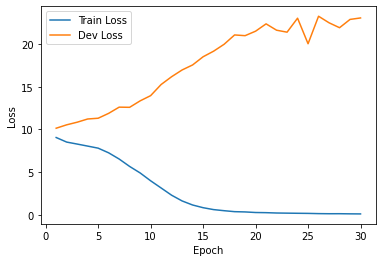

In [27]:
import matplotlib.pyplot as plt

t = list(range(1, 31))
plt.plot(t, train_losses, label="Train Loss")
plt.plot(t, dev_losses, label="Dev Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


![loss_plot](https://github.com/mynsng/mynsng.github.io/blob/master/assets/images/__results___26_0.png?raw=true)

학습 데이터 셋에 Overfitting이 일어나는 것을 확인할 수 있다.

## Answer Inference
모델의 Output을 활용해서 질문의 답을 찾는 코드를 작성하자.

In [28]:
model = BertForQuestionAnswering.from_pretrained('dump/model.30')
model.cuda()
model.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(36311, 256, padding_idx=0)
      (position_embeddings): Embedding(1024, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise

In [29]:
for idx, sample in zip(range(1, 4), indexed_train_dataset):
    print(f'------{idx}------')
    print('Context:', sample['context'])
    print('Question:', sample['question'])
    
    input_ids, token_type_ids = [
        torch.tensor(sample[key], dtype=torch.long, device="cuda")
        for key in ("input_ids", "token_type_ids")
    ]
    
    with torch.no_grad():
        start_logits, end_logits = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])
    start_logits.squeeze_(0), end_logits.squeeze_(0)
    
    #[1:-1] ; [sep] token 삭제 목적
    start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
    end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)
    probability = torch.triu(start_prob[:, None] @ end_prob[None, :])#MATMUL하여 결합토큰 확률로 만들기
    #triu ; 아래 삼각형 구간이 0으로 채워짐
    index = torch.argmax(probability).item()
    
    start = index // len(end_prob)
    end = index % len(end_prob)
    
    start = sample['position'][start][0]
    end = sample['position'][end][1]
    
    #context에서 정답의 위치 찾을 수 있음!
    print('Answer:', sample['context'][start:end])

------1------
Context: 한국은 캐나다와 자유무역협정(FTA)을 맺으면서 ‘경제영토’를 북미 전체로 확장하게 됐다. 캐나다는 G8 회원국이자 세계 11위 경제 대국이다. 한국과의 교역 규모는 지난해 99억2200만달러로 적은 편이지만 시장의 잠재 성장 가능성은 높다는 평가다. 특히 FTA 발효 2년 후 자동차 관세가 완전 철폐되면서 한국산 자동차의 가격 경쟁력이 높아질 전망이다. ○일본 앞서 시장 선점한·캐나다 FTA 체결로 가장 이득을 보는 품목은 자동차다. 캐나다는 한국의 5대 자동차시장이다. 지난해 캐나다에 수출한 자동차 수는 13만3000대. 캐나다는 현재 한국산 자동차에 부과하는 관세 6.1%를 발효 시점부터 2년 동안 단계적으로 없애기로 했다. 이렇게 되면 일본·유럽산 자동차보다 가격경쟁력에서 앞설 수 있게 된다. 북미자유무역협정(NAFTA) 회원국인 미국·멕시코산 자동차와 비슷한 조건에서 경쟁할 수 있다. 작년 캐나다 자동차시장 점유율은 미국 44.5%, 일본 33.6%, 한국 12.0%, 유럽 9.9% 등이다. 캐나다가 일본과 FTA 협상을 진행 중이고 유럽연합(EU)과는 추가 협상 문제로 발효가 늦어지고 있어 FTA 발효를 서두른다면 적어도 수년간은 시장 선점 효과를 누릴 수 있을 것으로 보인다. 김태년 한국자동차산업협회 이사는 “소형차의 경우 영업이익률이 3%밖에 안되기 때문에 관세 철폐 효과가 클 것으로 기대된다”고 말했다.주요 수출 품목인 자동차 부품도 3년 내 6%에 달하는 관세가 사라진다. 7%에 이르는 타이어 관세는 5년 뒤 완전 철폐된다. 관세율이 8%인 세탁기는 FTA 발효 즉시 없어지고, 6%인 냉장고 관세도 3년 내 철폐돼 가전제품 수출에도 파란불이 켜졌다. 평균 관세율 5.9%인 섬유도 대부분 3년 내 관세가 사라진다. 개성공단 원산지 인정 문제에 관해서는 향후 역외가공지역위원회 설립과 충족 기준을 논의하기로 했다. 이와 관련, 박근혜 대통령은 “개성공단 제품이 한국산으로 인정받아 관세 혜택을 받을 수 있도록

## Test 출력 파일 작성

In [30]:
test_dataset = TokenizedKoMRC.load('/content/drive/MyDrive/6th-goorm-project-2-korean-mrc/test.json')
test_dataset = IndexerWrappedDataset(test_dataset, indexer)
print("Number of Test Samples", len(test_dataset))
print(test_dataset[0])

Number of Test Samples 4008
{'guid': 'd14cb73158624cf094c546d856fd3c80', 'context': 'BMW 코리아(대표 한상윤)는 창립 25주년을 기념하는 ‘BMW 코리아 25주년 에디션’을 한정 출시한다고 밝혔다. 이번 BMW 코리아 25주년 에디션(이하 25주년 에디션)은 BMW 3시리즈와 5시리즈, 7시리즈, 8시리즈 총 4종, 6개 모델로 출시되며, BMW 클래식 모델들로 선보인 바 있는 헤리티지 컬러가 차체에 적용돼 레트로한 느낌과 신구의 조화가 어우러진 차별화된 매력을 자랑한다. 먼저 뉴 320i 및 뉴 320d 25주년 에디션은 트림에 따라 옥스포드 그린(50대 한정) 또는 마카오 블루(50대 한정) 컬러가 적용된다. 럭셔리 라인에 적용되는 옥스포드 그린은 지난 1999년 3세대 3시리즈를 통해 처음 선보인 색상으로 짙은 녹색과 풍부한 펄이 오묘한 조화를 이루는 것이 특징이다. M 스포츠 패키지 트림에 적용되는 마카오 블루는 1988년 2세대 3시리즈를 통해 처음 선보인 바 있으며, 보랏빛 감도는 컬러감이 매력이다. 뉴 520d 25주년 에디션(25대 한정)은 프로즌 브릴리언트 화이트 컬러로 출시된다. BMW가 2011년에 처음 선보인 프로즌 브릴리언트 화이트는 한층 더 환하고 깊은 색감을 자랑하며, 특히 표면을 무광으로 마감해 특별함을 더했다. 뉴 530i 25주년 에디션(25대 한정)은 뉴 3시리즈 25주년 에디션에도 적용된 마카오 블루 컬러가 조합된다. 뉴 740Li 25주년 에디션(7대 한정)에는 말라카이트 그린 다크 색상이 적용된다. 잔잔하면서도 오묘한 깊은 녹색을 발산하는 말라카이트 그린 다크는 장식재로 활용되는 광물 말라카이트에서 유래됐다. 뉴 840i xDrive 그란쿠페 25주년 에디션(8대 한정)은 인도양의 맑고 투명한 에메랄드 빛을 연상케 하는 몰디브 블루 컬러로 출시된다. 특히 몰디브 블루는 지난 1993년 1세대 8시리즈에 처음으로 적용되었던 만큼 이를 오마주하는 의미를 담

In [31]:
import csv
#pandas이용하지 않아도 된다! 짱신기
os.makedirs('out', exist_ok=True)
with torch.no_grad(), open('/content/drive/MyDrive/6th-goorm-project-2-korean-mrc/baseline.csv', 'w') as fd:
    writer = csv.writer(fd)
    writer.writerow(['Id', 'Predicted'])

    rows = []
    for sample in tqdm(test_dataset, "Testing"):
        input_ids, token_type_ids = [
            torch.tensor(sample[key], dtype=torch.long, device="cuda")
            for key in ("input_ids", "token_type_ids")
        ]
    
        with torch.no_grad():
            start_logits, end_logits = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])
        start_logits.squeeze_(0), end_logits.squeeze_(0)
    
        start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
        end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)
        probability = torch.triu(start_prob[:, None] @ end_prob[None, :])
        index = torch.argmax(probability).item()
    
        start = index // len(end_prob)
        end = index % len(end_prob)
    
        start = sample['position'][start][0]
        end = sample['position'][end][1]

        rows.append([sample["guid"], sample['context'][start:end]])
    
    writer.writerows(rows)

Testing:   0%|          | 0/4008 [00:00<?, ?it/s]